In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
cnt=0
import os
for dirname, _, filenames in os.walk('/kaggle/input/casia-dataset'):
    for filename in filenames:
        if(filename.endswith(".jpg")):
            os.path.join(dirname, filename)
            cnt+=1
            print(cnt,filename)
            
print(cnt)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1 Au_pla_30322.jpg
2 Au_ani_10197.jpg
3 Au_nat_00098.jpg
4 Au_nat_30407.jpg
5 Au_arc_20034.jpg
6 Au_sec_30053.jpg
7 Au_pla_30069.jpg
8 Au_nat_30645.jpg
9 Au_cha_30461.jpg
10 Au_arc_30140.jpg
11 Au_txt_00100.jpg
12 Au_arc_30059.jpg
13 Au_pla_30330.jpg
14 Au_cha_30427.jpg
15 Au_nat_30499.jpg
16 Au_pla_30222.jpg
17 Au_cha_30057.jpg
18 Au_ani_30279.jpg
19 Au_art_30550.jpg
20 Au_art_30302.jpg
21 Au_cha_30634.jpg
22 Au_art_30161.jpg
23 Au_arc_30669.jpg
24 Au_ani_30760.jpg
25 Au_pla_30164.jpg
26 Au_txt_00031.jpg
27 Au_arc_30446.jpg
28 Au_sec_00086.jpg
29 Au_cha_30102.jpg
30 Au_ani_30149.jpg
31 Au_sec_30137.jpg
32 Au_sec_30068.jpg
33 Au_nat_30617.jpg
34 Au_pla_30709.jpg
35 Au_sec_30491.jpg
36 Au_art_30239.jpg
37 Au_sec_30105.jpg
38 Au_cha_30476.jpg
39 Au_nat_30603.jpg
40 Au_cha_30599.jpg
41 Au_art_00075.jpg
42 Au_cha_30664.jpg
43 Au_arc_30649.jpg
44 Au_ani_30524.jpg
45 Au_pla_30139.jpg
46 Au_sec_20036.jpg
47 Au_arc_30034.jpg
48 Au_pla_30611.jpg
49 Au_art_30627.jpg
50 Au_sec_30189.jpg
51 Au_art

In [2]:
print("The total number of .jpg files read by the standard input reader is: ",cnt)

The total number of .jpg files read by the standard input reader is:  22258


**HOG FEATURE EXTRACTION**

In [6]:
import numpy as np
from skimage.feature import hog 
from skimage import io

def extract_hog_features(image, vital_points):
    hog_features = []
    
    for vp in vital_points:
        # Assuming vp is a (x, y) coordinate
        x, y = vp
        
        # Clamp coordinates to ensure they remain within the bounds
        x = np.clip(x, 16, image.shape[1] - 16)
        y = np.clip(y, 16, image.shape[0] - 16)

        # Extract a patch around the vital point for HOG calculation
        patch = image[y - 16:y + 16, x - 16:x + 16]  # 32x32 patch
        
        # Calculate HOG features for the patch
        features = hog(patch, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(features)

    # Check if any HOG features were extracted
    if len(hog_features) == 0:
        raise ValueError("No valid HOG features extracted from vital points.")
    
    # Calculate the mean of the feature vectors
    mean_hog_features = np.mean(hog_features, axis=0)
    return mean_hog_features

# Example usage (Make sure to define the image and vital_points variables):
# image = io.imread('path_to_image.jpg')
# vital_points = [(x1, y1), (x2, y2)]  # Replace with actual vital point coordinates
# hog_features = extract_hog_features(image, vital_points)


**DWT FEATURE EXTRACTION**

In [8]:
import pywt
import numpy as np

def extract_dwt_features(image):
    # Perform DWT on the image
    coeffs = pywt.dwt2(image, 'haar')  
    LL, (LH, HL, HH) = coeffs

    # Further divide LL into sub-bands 
    coeffs_LL = pywt.dwt2(LL, 'haar')
    LL1, (LH1, HL1, HH1) = coeffs_LL  # Further decompose LL
    
    # Example feature extraction from sub-bands
    def extract_features_from_band(band):
        return [
            np.mean(band),           # Mean
            np.std(band),            # Standard Deviation
            np.min(band),            # Minimum
            np.max(band),            # Maximum
            np.var(band),            # Variance
            np.percentile(band, 25), # 25th Percentile
            np.percentile(band, 75)  # 75th Percentile
        ]
    
    features = (
        extract_features_from_band(LL) +   # Features from LL
        extract_features_from_band(LH) +   # Features from LH
        extract_features_from_band(HL) +   # Features from HL
        extract_features_from_band(HH) +   # Features from HH
        extract_features_from_band(LL1) +  # Features from LL1
        extract_features_from_band(LH1) +  # Features from LH1
        extract_features_from_band(HL1) +  # Features from HL1
        extract_features_from_band(HH1)     # Features from HH1
    )
    np.array(features)
    return features




**COMBINE HOG FEATURE AND DWT FEATURE**

In [10]:
def combine_features(hog_vector, dwt_vector):
    combined_vector = np.concatenate((hog_vector, dwt_vector))
    return combined_vector

**EXTRACT IMAGES FROM THE DATASET AND FIND THE COMBINED FEATURE VECTOR**

In [11]:
import cv2
import os
import numpy as np

def find_vital_points(image):
    # No need to convert to BGR; keep it as grayscale
    gray_image = image
    
    # Shi-Tomasi corner detection
    corners = cv2.goodFeaturesToTrack(gray_image, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=3)

    # Convert corners to a list of (x, y) tuples with their response values
    vital_points = []
    if corners is not None:
        for corner in corners:
            x, y = corner.ravel()
            vital_points.append((int(x), int(y)))

        # Calculate response values for each corner
        # Note: corners contains the same points, we need their responses
        response_values = cv2.cornerMinEigenVal(gray_image, blockSize=3, ksize=3)

        # Create a list of tuples with corner coordinates and their response values
        corner_response = [(vital_points[i], response_values[int(corners[i][0][1]), int(corners[i][0][0])]) 
                           for i in range(len(vital_points))]

        # Sort by response value (higher is better)
        corner_response.sort(key=lambda x: x[1], reverse=True)

        # Select the top 3 most important corners based on response values
        vital_points = [corner for corner, _ in corner_response[:3]]

    return vital_points



# Initialize lists to store images and labels
images = []
labels = []

# Path to the CASIA1 dataset directory
casia1_path = '/kaggle/input/casia-dataset'

# Function to get label from the filename
def get_label(filename):
    if filename.startswith('Au'):
        return 1  # Authentic
    elif filename.startswith(('Sp','Tp')):
        return 0  # Spoofed
    else:
        raise ValueError("Filename does not start with 'Au' or 'Sp'")

# Load images and labels
for dirname, _, filenames in os.walk(casia1_path):
    for filename in filenames:
        # Check if the file has a .jpg 
        if filename.endswith(".jpg"):
            image_path = os.path.join(dirname, filename)

            # Load the image and convert to grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Resize the image to 256x256
            image = cv2.resize(image, (256, 256))

            # Append the resized image to the images array
            images.append(image)

            # Get the label from the filename and append to labels array
            label = get_label(filename)
            labels.append(label)

# Convert lists to NumPy arrays
labels = np.array(labels)
images = np.array(images)

images=images[:11129]
labels=labels[:11129]
# Initialize lists for feature vectors
hog_features_list = []
dwt_features_list = []
combined_features_list = []

# Process each image
for image in images:
    # Find vital points in the image
    vital_points = find_vital_points(image)

    # Extract HOG features using the identified vital points
    hog_features = extract_hog_features(image, vital_points)
    hog_features_list.append(hog_features)

    # Extract DWT features
    dwt_features = extract_dwt_features(image)
    dwt_features_list.append(dwt_features)

    # Combine HOG and DWT features
    combined_features = combine_features(hog_features, dwt_features)
    combined_features_list.append(combined_features)

# Convert feature lists to NumPy arrays
hog_features = np.array(hog_features_list)
dwt_features = np.array(dwt_features_list)
combined_features = np.array(combined_features_list)

# At this point, :
# - `images` containing all the loaded images
# - `labels` containing the corresponding labels
# - `hog_features` containing the HOG feature vectors
# - `dwt_features` containing the DWT feature vectors
# - `combined_features` containing the combined HOG-DWT feature vectors


In [12]:
combined_features.shape

(11129, 380)

Epoch 1/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5965 - loss: 94.0025 - val_accuracy: 0.2600 - val_loss: 5.8617
Epoch 2/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6047 - loss: 20.5802 - val_accuracy: 0.7434 - val_loss: 23.2738
Epoch 3/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6071 - loss: 17.4396 - val_accuracy: 0.7440 - val_loss: 13.3667
Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6141 - loss: 7.6139 - val_accuracy: 0.7451 - val_loss: 13.3966
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6042 - loss: 11.1383 - val_accuracy: 0.4447 - val_loss: 1.8848
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5945 - loss: 9.3409 - val_accuracy: 0.2819 - val_loss: 6.2035
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6016 - loss: 8.3787 - val_accuracy: 0.7451 - val_loss: 10.7010
Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6138 - loss: 5.9062 -

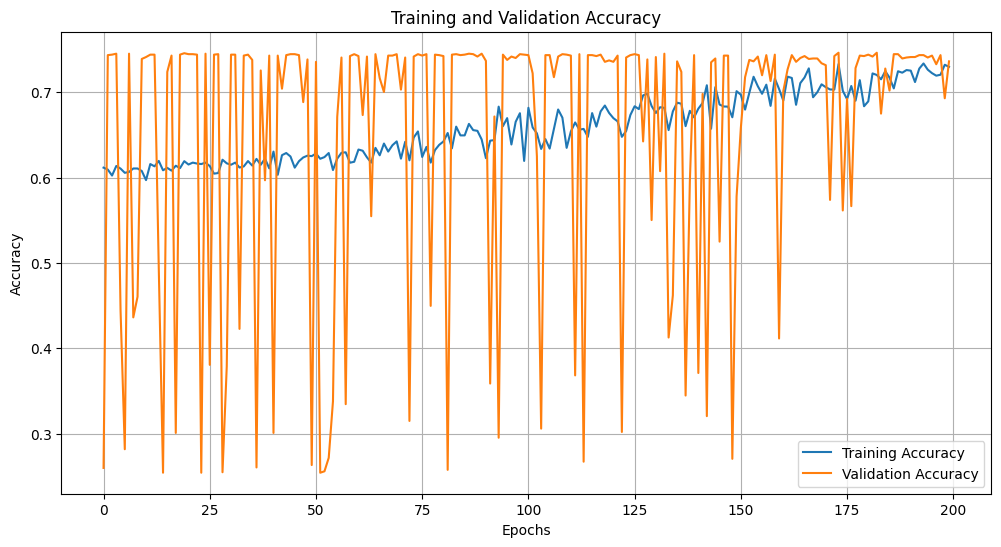

In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.optimizers import Adam

# Assuming combined_features (X) and labels (y) are already defined
# Prepare data for training
X= combined_features
y = to_categorical(labels) 


# Reshape combined_features to appropriate dimensions
n_samples = X.shape[0]
X = X.reshape(n_samples, 20, 19, 1)  # Adjust dimensions accordingly

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(20, 19, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
# Only pool if the resulting dimensions are large enough
if X.shape[1] > 1 and X.shape[2] > 1: 
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the results to feed into the Dense layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Output Layer
model.add(Dense(y.shape[1], activation='softmax'))  # Using the number of classes dynamically

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store training history
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print training, validation, and test accuracies
train_accuracy = history.history['accuracy'][-1]  # Final training accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Final validation accuracy
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')  # Explicitly printing test accuracy

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()



Epoch 1/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4643 - loss: 450.6220 - val_accuracy: 0.6255 - val_loss: 9.1143
Epoch 2/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5945 - loss: 9.2291 - val_accuracy: 0.7181 - val_loss: 7.8118
Epoch 3/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6301 - loss: 7.1151 - val_accuracy: 0.5149 - val_loss: 4.9211
Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6127 - loss: 5.0014 - val_accuracy: 0.7092 - val_loss: 3.3614
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6160 - loss: 3.6796 - val_accuracy: 0.4060 - val_loss: 4.5220
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6182 - loss: 4.1899 - val_accuracy: 0.3223 - val_loss: 7.0330
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5961 - loss: 5.6354 - val_accuracy: 0.7361 - val_loss: 4.4871
Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6246 - loss: 2.4943 - val_a

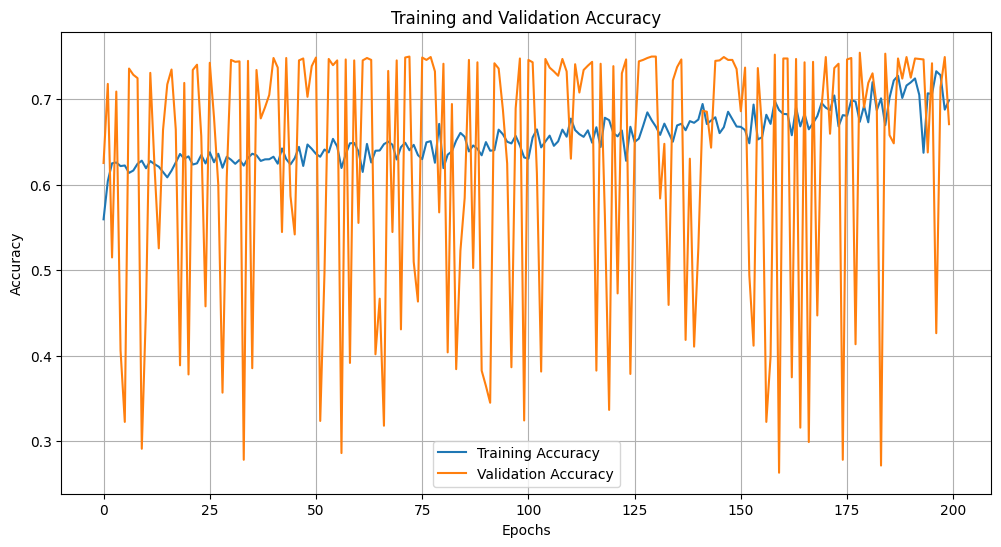

In [20]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.optimizers import Adam

# Assuming combined_features (X) and labels (y) are already defined
# Prepare data for training
X_hog = hog_features  # Replace with actual HOG features variable
X_dwt = dwt_features  # Replace with actual DWT features variable
y = to_categorical(labels) 

# Reshape combined_features to appropriate dimensions
n_samples = X_hog.shape[0]
X_hog = X_hog.reshape(n_samples, 18, 18, 1)  # Reshape HOG features to (18, 18, 1)
X_dwt = X_dwt.reshape(n_samples, 56)  # Keep DWT features as 1D (56,)

# Split the dataset into training and testing sets
X_hog_train, X_hog_test, X_dwt_train, X_dwt_test, y_train, y_test = train_test_split(X_hog, X_dwt, y, test_size=0.2, random_state=42)

# Define CNN model for HOG features
input_hog = Input(shape=(18, 18, 1))
x_hog = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_hog)
x_hog = MaxPooling2D(pool_size=(2, 2))(x_hog)

x_hog = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x_hog)
x_hog = MaxPooling2D(pool_size=(2, 2))(x_hog)

x_hog = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x_hog)
if x_hog.shape[1] > 1 and x_hog.shape[2] > 1: 
    x_hog = MaxPooling2D(pool_size=(2, 2))(x_hog)

x_hog = Flatten()(x_hog)

# Define Dense model for DWT features
input_dwt = Input(shape=(56,))  # DWT features are kept as a 1D input
x_dwt = Dense(64, activation='relu')(input_dwt)  # Dense layer for DWT features
x_dwt = Dense(32, activation='relu')(x_dwt)  # Additional dense layer if needed

# Concatenate the outputs from both branches
concatenated = Concatenate()([x_hog, x_dwt])

# Fully Connected Layer
dense = Dense(128, activation='relu')(concatenated)

# Output Layer
output = Dense(y.shape[1], activation='softmax')(dense)  # Using the number of classes dynamically

# Create the model
model = Model(inputs=[input_hog, input_dwt], outputs=output)

# Set learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and store training history
history = model.fit([X_hog_train, X_dwt_train], y_train, epochs=200, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_hog_test, X_dwt_test], y_test)

# Print training, validation, and test accuracies
train_accuracy = history.history['accuracy'][-1]  # Final training accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Final validation accuracy
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')  # Explicitly printing test accuracy

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [10]:
# Save the model
model.save('cnn_model.h5')
print("Model saved as cnn_model.h5")


Model saved as cnn_model.h5


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Select 5 images from the test dataset
num_test_images = 5
X_sample = X_test[:num_test_images]
y_true = y_test[:num_test_images]

# Predict using the trained model
predictions = model.predict(X_sample)

# Convert the predictions from one-hot encoded to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_true, axis=1)

# Map the labels to "authentic" or "spoofed"
label_mapping = {0: 'Authentic', 1: 'Spoofed'}
predicted_categories = [label_mapping[label] for label in predicted_labels]
true_categories = [label_mapping[label] for label in true_labels]

# Print the results
for i in range(num_test_images):
    print(f"Image {i+1}:")
    
    print(f"  True Label: {true_categories[i]}")
    print(f"  Predicted Label: {predicted_categories[i]}")
    print("-" * 30)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image 1:
  True Label: Spoofed
  Predicted Label: Spoofed
------------------------------
Image 2:
  True Label: Authentic
  Predicted Label: Authentic
------------------------------
Image 3:
  True Label: Authentic
  Predicted Label: Authentic
------------------------------
Image 4:
  True Label: Spoofed
  Predicted Label: Spoofed
------------------------------
Image 5:
  True Label: Spoofed
  Predicted Label: Spoofed
------------------------------
